### Introduction
#### A brief analysis of the churn rate of the telecomunications **Telco Company** ([Link to data](https://www.kaggle.com/blastchar/telco-customer-churn)) using the **CRISP-DM** process: 
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Main objectives: 
- Better understand the CRISP-DM process, specifically focusing on:
    - Investigating the dataset & setting up business questions
    - Preparing & cleaning up data 
    - Modeling & evaluating the dataset
- Become familiarized with simple churn analysis

In [1]:
# Import modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

cwd = os.getcwd()
ls = os.listdir()
print(cwd)
print(ls)

c:\Users\kwojn\OneDrive\Documents\DataScience\churn_analysis\churn_analysis
['.git', '.ipynb_checkpoints', 'churn_analysis.ipynb', 'data', 'README.md']


### Import data

In [2]:
# dataset
# Import
df = pd.read_csv('.\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Rows & columns
rows = df.shape[0]
cols = df_clean.shape[1]
print(f'Number of rows = {rows} & number of columns = {cols}')

# Dataset overview
df.head()


Number of rows = 7043 & number of columns = 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Business questions to be analyzed in notebook
1. What are the statistics of monthly & total charges of people that are customers vs people that churned?
2. What are the statistics of the tenure of people that are customers vs people that churned?
3. What services do people that are customers prefer vs people that churn? (nice tornado plot?)
4. Can we predict the churn rate based on the quantitative variables & how does the prediction improve when we add the categorical variables?

In [3]:
# Check dtypes of variables
df.dtypes.to_frame().T

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,object,object,int64,object,object,int64,object,object,object,object,...,object,object,object,object,object,object,object,float64,object,object


In [7]:
# --> Will give an ERROR!!!!
# Convert TotalCharges column to numeric variable 
pd.to_numeric(df['TotalCharges'], errors = 'raise')

ValueError: Unable to parse string " " at position 488

#### Clean up table

In [8]:
# Number of null or empty strings per variable
# Clean up data-set
# Nans
total_null_count = 0
index_null_values = []

#Check how many empty & blank strings in table
df_objects = df.select_dtypes(include=['object']).copy()
for col in df.columns:
    # print(col)
    if col in df_objects.columns:
        # Search for empty strings & blank with regex expression r"^\s*$" in categorical variables
        col_null_count = df[df[col].str.contains(r"^\s*$")==True][col].count()
        col_index_null_values = df[df[col].str.contains(r"^\s*$")==True].index.tolist()
        # print(str(col) + "\t" + str(df[col].dtypes) + "\t" + str(col_null_count))
        total_null_count += col_null_count
        index_null_values.extend(col_index_null_values)
        
    else: 
        # search for NaNs in numeric variabls
        col_null_count = df[col].isna().sum()
        col_index_null_values = df[np.isnan(df[col])].index.tolist()
        # print(str(col) + "\t" + str(df[col].dtypes) + "\t" + str(col_null_count))
        total_null_count += col_null_count
        index_null_values.extend(col_index_null_values)

print(f'Number of nan or empty values in table = {total_null_count}')
print(f'Nan or empty table rows: {index_null_values}')


Number of nan or empty values in table = 11
Nan or empty table rows: [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


In [21]:
# Clean rows that contain Nan or empty values (in total charges)
df_clean = df.drop(index_null_values, inplace=False).copy()
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors = 'raise')

# pd.to_numeric(df_clean['TotalCharges'], errors = 'raise')


rows_clean = df_clean.shape[0]
cols_clean = df_clean.shape[1]

print(f'New number of rows = {rows_clean} vs old number of rows = {rows}')
print(f'New number of cols = {cols_clean} vs old number of cols = {cols}')

New number of rows = 7032 vs old number of rows = 7043
New number of cols = 21 vs old number of cols = 21


In [22]:
df_clean.dtypes.to_frame().T

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,object,object,int64,object,object,int64,object,object,object,object,...,object,object,object,object,object,object,object,float64,float64,object


##### What are the statistics of monthly & total charges of customers vs people that churn?

### Total charges

In [36]:
total_charges_customer = df_clean[df_clean.Churn == 'No']['TotalCharges']
total_charges_churned = df_clean[df_clean.Churn == 'Yes']['TotalCharges']

print(f'Number of customers: {total_charges_customer.shape[0]}')
print(f'Number churned: {total_charges_churned.shape[0]}')

Number of customers: 5163
Number churned: 1869


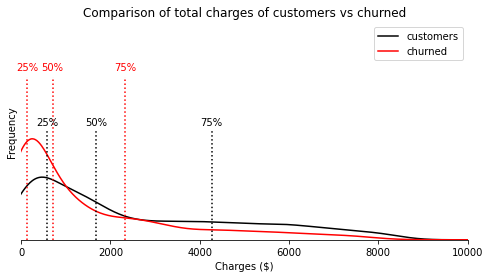

In [47]:
fig, ax = plt.subplots(figsize = (8,4))
# PLOTS
# Histogram
# total_charges_customer.plot(kind = "hist", color = 'grey', alpha=0.5, density = True, bins = 15, label='customers', ax=ax) # change density to true, because KDE uses density
# total_charges_churned.plot(kind = "hist", color = 'salmon', alpha=0.5, density = True, bins = 15, label='churned', ax=ax) # change density to true, because KDE uses density

# KDE
total_charges_customer.plot(kind = "kde", color='black', label='customers', ax=ax)
total_charges_churned.plot(kind = "kde", color='red', label='churned', ax=ax)

# Plot percentiles
# total_charges_customer.plot(kind = "kde", color='black', label='TotalCharges')
# total_charges_churned.plot(kind = "kde", color='red', label='TotalCharges')
quantile_labels = total_charges_customer.describe()[-4:-1].index
quantiles_customer = total_charges_customer.describe()[-4:-1]
quantiles_churned = total_charges_churned.describe()[-4:-1]
trans = ax.get_xaxis_transform()

for i in range(3):
    ax.axvline(quantiles_customer[i], color='black', ymax=0.5, alpha = 1, linestyle = ":")
    ax.axvline(total_charges_churned.describe()[-4:-1][i], color='red', ymax=0.75, alpha = 1, linestyle = ":")
    plt.text(quantiles_customer[i], .52, str(quantile_labels[i]), color = 'black', transform=trans, ha='center', va='bottom')
    plt.text(quantiles_churned[i], .77, str(quantile_labels[i]), color = 'red', transform=trans, ha='center', va='bottom')

# X & Y labels & title
ax.set_xlabel("Charges ($)"), ax.set_ylabel('Frequency'), ax.set_title("Comparison of total charges of customers vs churned")
# Configure plot
ax.set_xlim(0, 10000)
ax.set_ylim(0, 0.001)
# ax.tick_params(left = False, bottom = False)
ax.set_yticks([])
ax.spines[['left', 'right', 'top']].set_visible(False)
ax.legend()

### Monthly charges

In [23]:
# filter data
# split data set into customers vs churned 
monthly_charges_customer = df_clean[df_clean.Churn == 'No']['MonthlyCharges']
monthly_charges_churned = df_clean[df_clean.Churn == 'Yes']['MonthlyCharges']
# split data set into old customers vs old churned (without new customers, where TotalCharges = 0)
# monthly_charges_customer_old = df[(df.Churn == 'No') & (df.TotalCharges != 0)]['MonthlyCharges'] 
# monthly_charges_churned_old = df[(df.Churn == 'Yes') & (df.TotalCharges != 0)]['MonthlyCharges']

monthly_charges_customer_old = df_clean['TotalCharges'] 
monthly_charges_churned_old = df_clean[df_clean.TotalCharges == 0]['TotalCharges']

# print(monthly_charges_customer.describe()[0])
# print(monthly_charges_churned.describe()[0])
# print(monthly_charges_customer_old.describe())
# print(monthly_charges_churned_old.describe()[0])


# TODO:
# --> plot histograms as line plot: https://towardsdatascience.com/take-your-histograms-to-the-next-level-using-matplotlib-5f093ad7b9d3
# --> compare average / p10 / p90 percentiles + skeweness
# --> What if we take away the customers that just joined (i.e. have no total charges)?
# --> Is there a clear difference in the monthly & total charges between people that stay vs people that churned? 

5163.0
1869.0
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64
0.0


In [174]:
df_clean.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

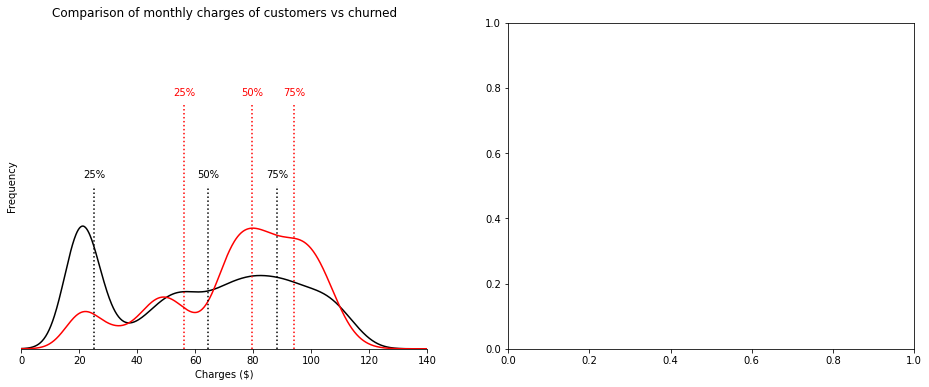

In [148]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))
# PLOTS
# Histogram
# monthly_charges_customer.plot(kind = "hist", color = 'grey', alpha=0.5, density = True, bins = 15, ax=ax[0]) # change density to true, because KDE uses density
# monthly_charges_churned.plot(kind = "hist", color = 'salmon', alpha=0.5, density = True, bins = 15, ax=ax[0]) # change density to true, because KDE uses density

# KDE
monthly_charges_customer.plot(kind = "kde", color='black', label='MonthlyCharges', ax=ax[0])
monthly_charges_churned.plot(kind = "kde", color='red', label='MonthlyCharges', ax=ax[0])

# Plot percentiles
# monthly_charges_customer.plot(kind = "kde", color='black', label='MonthlyCharges')
# monthly_charges_churned.plot(kind = "kde", color='red', label='MonthlyCharges')
quantile_labels = monthly_charges_customer.describe()[-4:-1].index
quantiles_customer = monthly_charges_customer.describe()[-4:-1]
quantiles_churned = monthly_charges_churned.describe()[-4:-1]
trans = ax[0].get_xaxis_transform()

for i in range(3):
    ax[0].axvline(quantiles_customer[i], color='black', ymax=0.5, alpha = 1, linestyle = ":")
    ax[0].axvline(monthly_charges_churned.describe()[-4:-1][i], color='red', ymax=0.75, alpha = 1, linestyle = ":")
    plt.text(quantiles_customer[i], .52, str(quantile_labels[i]), color = 'black', transform=trans, ha='center', va='bottom')
    plt.text(quantiles_churned[i], .77, str(quantile_labels[i]), color = 'red', transform=trans, ha='center', va='bottom')

# X & Y labels & title
ax[0].set_xlabel("Charges ($)"), ax[0].set_ylabel('Frequency'), ax[0].set_title("Comparison of monthly charges of customers vs churned")
# Configure plot
ax[0].set_xlim(0, 140), ax[0].set_ylim(0, 0.05)
# ax.tick_params(left = False, bottom = False)
ax[0].set_yticks([])
ax[0].spines[['left', 'right', 'top']].set_visible(False)

# plt.show()

In [57]:
monthly_charges_customer.describe()[-4:-1]

25%    25.100
50%    64.425
75%    88.400
Name: MonthlyCharges, dtype: float64

In [54]:
# Calculate quantiles
quantiles = [0.1, 0.5, 0.9]

# Caluclate quantile statistics
monthly_charges_customer_stats = monthly_charges_customer.describe()[-4:-1]
monthly_charges_churned_stats = monthly_charges_churned.describe()
# monthly_charges_stats, monthly_charges_churned_stats
monthly_charges_customer_stats[-4:-1]
# type(monthly_charges_customer_stats[0])

25%    25.100
50%    64.425
75%    88.400
Name: MonthlyCharges, dtype: float64